In [83]:
from dotenv import load_dotenv
from label_studio_sdk.client import LabelStudio
from glob import glob
from pathlib import Path
from sqlite3 import connect
from typing import Tuple, Any
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import deque

In [3]:
load_dotenv()

True

In [4]:
LABEL_STUDIO_URL = "https://labeler.e4e.ucsd.edu"
LABEL_STUDIO_API_KEY = os.environ["LABEL_STUDIO_API_KEY"]
LABEL_STUDIO_PROJECT_ID = 46

LABEL_STUDIO_URL, LABEL_STUDIO_API_KEY, LABEL_STUDIO_PROJECT_ID

('https://labeler.e4e.ucsd.edu',
 '88bd176c0035671620e8effc8c23ecf37d942310',
 46)

In [5]:
ipad_camera_intrinsics = np.array([[1604.2147, 0.0, 956.5816],
                                   [0.0, 1604.2147, 717.7617],
                                   [0.0, 0.0, 1.0]])
iphone_camera_intrinsics = np.array([[1375.0719, 0.0, 968.6433],
                                     [0.0, 1375.0719, 723.04926],
                                     [0.0, 0.0, 1.0]])

In [6]:
label_studio = LabelStudio(base_url=LABEL_STUDIO_URL, api_key=LABEL_STUDIO_API_KEY)

label_studio

In [7]:
rgbs = [Path(g).absolute().resolve() for g in glob("../data/2025.06.27.FishSense.SanDiego/**/**/FSM/rgb_*.jpg", recursive=True)]
timestamp_to_rgb_map = {int(f.stem[4:]):f for f in rgbs}


# rgbs = "/Users/sijanshrestha/Projects/e4e/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-05/iPad/FSM/rgb_1751472677.jpg"
# timestamp = int(Path(rgbs).stem.split('_')[1])
# timestamp_to_rgb_map = {timestamp: Path(rgbs)}

timestamp_to_rgb_map

{1751059596: PosixPath('/home/chris/Repos/school/e4e/fishsense/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751059596.jpg'),
 1751059200: PosixPath('/home/chris/Repos/school/e4e/fishsense/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751059200.jpg'),
 1751059821: PosixPath('/home/chris/Repos/school/e4e/fishsense/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751059821.jpg'),
 1751059518: PosixPath('/home/chris/Repos/school/e4e/fishsense/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751059518.jpg'),
 1751047797: PosixPath('/home/chris/Repos/school/e4e/fishsense/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-00/iPad/FSM/rgb_1751047797.jpg'),
 1751048739: PosixPath('/home/chris/Repos/school/e4e/fishsense/2025-07-21_fishsense-mobile-data-processin

In [8]:
def get_depth_map_and_confidence_map(timestamp: int, database_path: Path) -> Tuple[np.ndarray[float], np.ndarray[int]]:
    with connect(database_path) as connection:
        cursor = connection.cursor()
        query = """
        SELECT depth_bytes, depth_width, depth_height, confidence_bytes, confidence_width, confidence_height FROM photos
        WHERE utc_unix_timestamp = ?"""

        cursor.execute(query, (timestamp,))
        row = cursor.fetchone()

        depth_width = row[1]
        depth_height = row[2]
        depth_map = np.frombuffer(row[0], dtype=np.float32).reshape((depth_height, depth_width))

        confidence_width = row[4]
        confidence_height = row[5]
        confidence_map = np.frombuffer(row[3], dtype=np.int8).reshape((confidence_height, confidence_width))

    return depth_map, confidence_map

In [ ]:
def get_neighbors(depth_map: np.ndarray[float], node: np.ndarray[int], epsilon=0.005):
    height, width = depth_map.shape
    max_pos = np.array([width, height])

    up = node + np.array([0, -1])
    down = node + np.array([0, 1])
    left = node + np.array([-1, 0])
    right = node + np.array([1, 0])

    if np.all(up < max_pos) and np.all(up >= 0) and np.all(np.abs(depth_map[node[1], node[0]] - depth_map[up[1], up[0]]) <= epsilon):
        yield up
    if np.all(down < max_pos) and np.all(down >= 0) and np.all(np.abs(depth_map[node[1], node[0]] - depth_map[down[1], down[0]]) <= epsilon):
        yield down
    if np.all(left < max_pos) and np.all(left >= 0) and np.all(np.abs(depth_map[node[1], node[0]] - depth_map[left[1], left[0]]) <= epsilon):
        yield left
    if np.all(right < max_pos) and np.all(right >= 0) and np.all(np.abs(depth_map[node[1], node[0]] - depth_map[right[1], right[0]]) <= epsilon):
        yield right

def correct_labels(depth_map: np.ndarray[float], depth_annotations: np.ndarray[float]):
    x2 = depth_annotations[:, 0].max()
    x1 = depth_annotations[:, 0].min()

    y2 = depth_annotations[:, 1].max()
    y1 = depth_annotations[:, 1].min()

    x_middle = x1 + (x2 - x1) / 2
    y_middle = y1 + (y2 - y1) / 2

    start_node = np.round(np.array([x_middle, y_middle])).astype(int)

    visited = set()
    current_component = []
    queue = deque([start_node])
    visited.add(tuple(start_node))

    while queue:
        current_node = queue.popleft()
        current_component.append(current_node)

        for neighbor in get_neighbors(depth_map, current_node):
            if tuple(neighbor) not in visited:
                visited.add(tuple(neighbor))
                queue.append(neighbor)

    current_component = np.array(current_component)

    arg_0 = np.argmin(np.sum((depth_annotations[0, :] - np.array(current_component))**2, axis=1))
    depth_annotations[0, :] = current_component[arg_0, :]

    arg_1 = np.argmin(np.sum((depth_annotations[1, :] - np.array(current_component))**2, axis=1))
    depth_annotations[1, :] = current_component[arg_1, :]

    return depth_annotations

In [102]:
def compute_fish_length(task: Any, timestamp: int, rgb_path: Path, database_path: Path) -> Tuple[float, int, np.ndarray[np.uint8], np.ndarray[float], np.ndarray[np.uint8], np.ndarray[float], np.ndarray[float]]:
    rgb_image = cv2.imread(str(rgb_path))   
    depth_map, confidence_map = get_depth_map_and_confidence_map(timestamp, database_path)

    snout_results = [r for a in task.annotations for r in a["result"] if any(k == "Snout" for k in r["value"]["keypointlabels"])]
    fork_results = [r for a in task.annotations for r in a["result"] if any(k == "Fork" for k in r["value"]["keypointlabels"])]
        
    snout = snout_results[0]
    fork = fork_results[0]

    snout = [snout["value"]["x"] / 100, snout["value"]["y"] / 100]
    fork = [fork["value"]["x"] / 100, fork["value"]["y"] / 100]

    annotations = np.array([snout, fork])

    rgb_height, rgb_width, _ = rgb_image.shape
    rgb_shape = np.array([rgb_width, rgb_height])
    rgb_annotations = annotations * rgb_shape

    depth_height, depth_width = depth_map.shape
    depth_map_shape = np.array([depth_width, depth_height])
    depth_annotations = correct_labels(depth_map, annotations * depth_map_shape)

    camera_intrinsics = ipad_camera_intrinsics if "iPad" in str(rgb_path) else iphone_camera_intrinsics

    depths = depth_map[depth_annotations[:, 1].astype(int), depth_annotations[:, 0].astype(int)]
    confidences = confidence_map[depth_annotations[:, 1].astype(int), depth_annotations[:, 0].astype(int)]

    points3d = np.linalg.inv(camera_intrinsics) @ np.array([rgb_annotations[:, 0], rgb_annotations[:, 1], np.ones_like(rgb_annotations[:, 0])])
    for idx, depth_pixel in enumerate(depths):
        points3d[idx, :] *= depth_pixel

    fish_length = np.linalg.norm(points3d[:, 0] - points3d[:, 1])
    confidence = np.min(confidences)

    return fish_length, confidence, rgb_image, depth_map, confidence_map, rgb_annotations, depth_annotations

In [206]:
fish_length_data = []

for task in label_studio.tasks.list(project=LABEL_STUDIO_PROJECT_ID):
    timestamp = int(Path(task.storage_filename).stem[4:])
    if timestamp not in timestamp_to_rgb_map:
        continue

    if not any(a["result"] for a in task.annotations):
        continue

    rgb_path = timestamp_to_rgb_map[timestamp]
    database_path = rgb_path.parent / "database.sqlite"

    # if timestamp == 1751410897:
    #     break

    fish_length, confidence, rgb_image, depth_map, confidence_map, rgb_annotations, depth_annotations = compute_fish_length(task, timestamp, rgb_path, database_path)
        
    parts = rgb_path.parts
    ed_value = parts[-4]
    device = parts[-3]

    fish_length_data.append({
        'timestamp': timestamp,
        'ED': ed_value,
        'device': device,
        'rgb_path': parts[-4] +"/" + parts[-3] + "/" + parts[-2] + "/" + parts[-1],
        'fish_length_mm': fish_length * 1000,
        'confidence': confidence,
        })     
    print(f"Timestamp {timestamp} ({ed_value}, {device}): Fish length = {fish_length * 1000:.2f} mm")

Timestamp 1751040799 (ED-00, iPad): Fish length = 348.72 mm
Timestamp 1751048739 (ED-00, iPad): Fish length = 292.29 mm
Timestamp 1751048791 (ED-00, iPad): Fish length = 290.58 mm
Timestamp 1751048875 (ED-00, iPad): Fish length = 747.02 mm
Timestamp 1751050086 (ED-00, iPad): Fish length = 375.79 mm
Timestamp 1751050103 (ED-00, iPad): Fish length = 384.97 mm
Timestamp 1751057767 (ED-00, iPad): Fish length = 534.08 mm
Timestamp 1751057870 (ED-00, iPad): Fish length = 339.07 mm
Timestamp 1751058323 (ED-00, iPad): Fish length = 332.02 mm
Timestamp 1751058522 (ED-00, iPad): Fish length = 750.73 mm
Timestamp 1751059022 (ED-00, iPad): Fish length = 306.26 mm
Timestamp 1751059104 (ED-00, iPad): Fish length = 359.55 mm
Timestamp 1751059200 (ED-00, iPad): Fish length = 370.56 mm
Timestamp 1751059296 (ED-00, iPad): Fish length = 309.20 mm
Timestamp 1751059385 (ED-00, iPad): Fish length = 310.41 mm
Timestamp 1751059462 (ED-00, iPad): Fish length = 338.92 mm
Timestamp 1751059518 (ED-00, iPad): Fish

In [205]:
fish_length, confidence, rgb_image, depth_map, confidence_map, rgb_annotations, depth_annotations = compute_fish_length(task, timestamp, rgb_path, database_path)

fish_length, confidence, task.id, rgb_path

(np.float64(0.28542949082563257),
 np.int8(1),
 221700,
 PosixPath('/home/chris/Repos/school/e4e/fishsense/2025-07-21_fishsense-mobile-data-processing/data/2025.06.27.FishSense.SanDiego/ED-04/iPad/FSM/rgb_1751410897.jpg'))

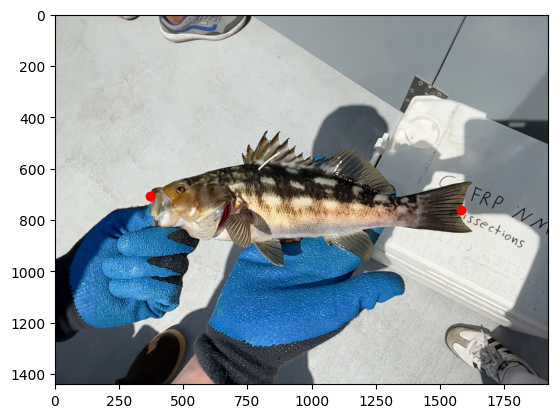

In [203]:
plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
plt.plot(rgb_annotations[:, 0], rgb_annotations[:, 1], 'ro')

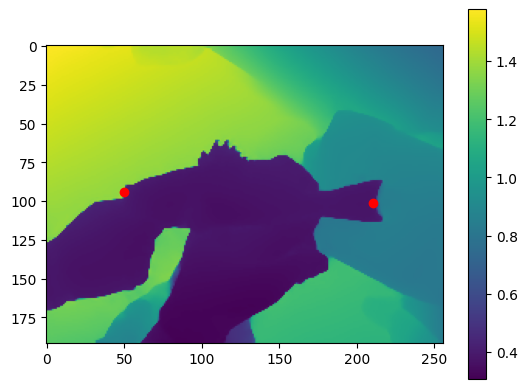

In [194]:
plt.imshow(depth_map)
plt.plot(depth_annotations[:, 0], depth_annotations[:, 1], 'ro')
plt.colorbar()

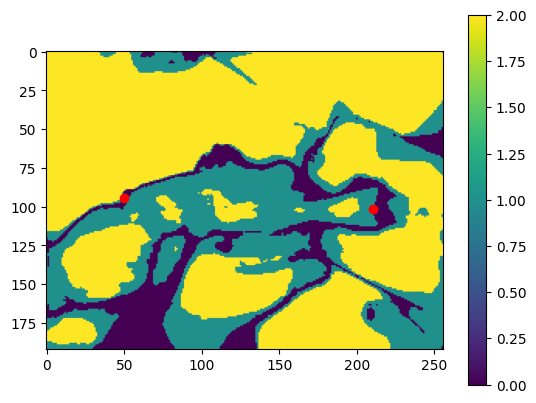

In [116]:
plt.imshow(confidence_map)
plt.plot(depth_annotations[:, 0], depth_annotations[:, 1], 'ro')
plt.colorbar()

In [10]:
parts[-4]

'ED-06'

In [11]:
parts[-4] +"/" + parts[-3] + "/" + parts[-2] + "/" + parts[-1]

'ED-06/iPhone/FSM/rgb_1751568529.jpg'

In [207]:
import pandas as pd
fish_length_df = pd.DataFrame(fish_length_data)

In [78]:
fish_length_df.head()

,timestamp,ED,device,rgb_path,fish_length_mm,confidence
0,1751040799,ED-00,iPad,ED-00/iPad/FSM/rgb_1751040799.jpg,329.832899,1
1,1751048739,ED-00,iPad,ED-00/iPad/FSM/rgb_1751048739.jpg,291.964926,0
2,1751048791,ED-00,iPad,ED-00/iPad/FSM/rgb_1751048791.jpg,928.478965,0
3,1751048875,ED-00,iPad,ED-00/iPad/FSM/rgb_1751048875.jpg,938.573835,0
4,1751050086,ED-00,iPad,ED-00/iPad/FSM/rgb_1751050086.jpg,357.914635,2


In [208]:
fish_length_df.to_csv("fish_length_prediction.csv")

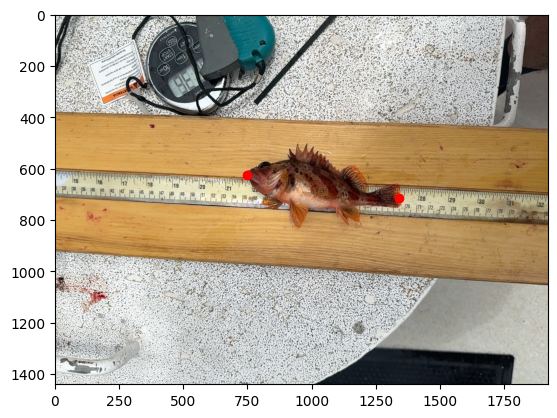

In [15]:
plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
plt.plot(rgb_annotations[:, 0], rgb_annotations[:, 1], 'ro')

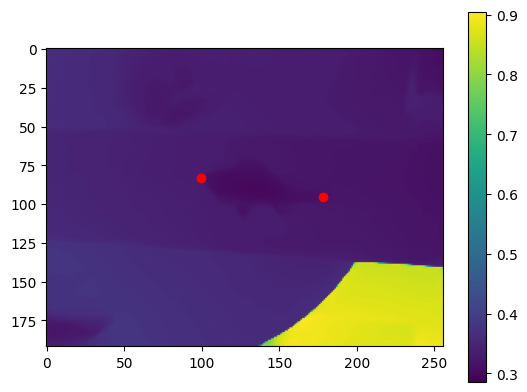

In [16]:
plt.imshow(depth_map)
plt.plot(depth_annotations[:, 0], depth_annotations[:, 1], 'ro')
plt.colorbar()

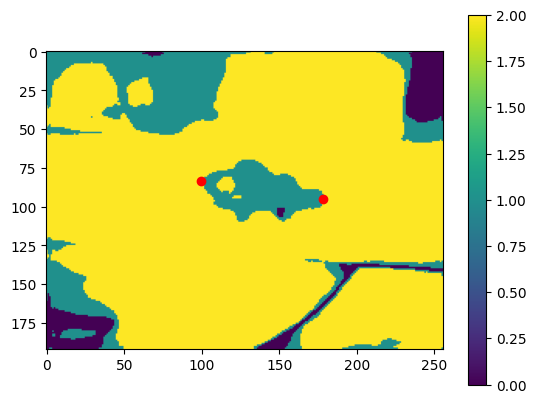

In [17]:
plt.imshow(confidence_map)
plt.plot(depth_annotations[:, 0], depth_annotations[:, 1], 'ro')
plt.colorbar()

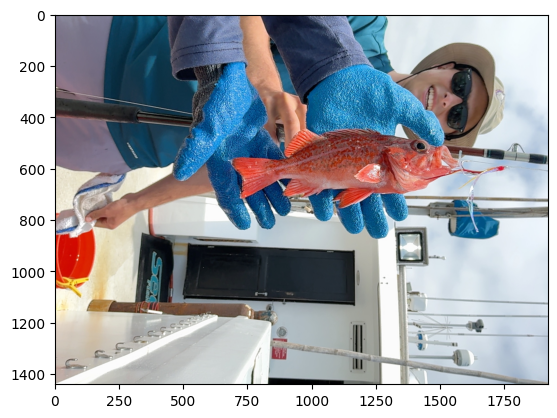

In [22]:
image = cv2.cvtColor(cv2.imread("../data/2025.06.27.FishSense.SanDiego/ED-06/iPad/FSM/rgb_1751571501.jpg"), cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [20]:
image = Image.open("../data/2025.06.27.FishSense.SanDiego/ED-05/iPad/FSM/rgb_1751472677.jpg")
image.show()

/usr/bin/eog: symbol lookup error: /snap/core20/current/lib/x86_64-linux-gnu/libpthread.so.0: undefined symbol: __libc_pthread_init, version GLIBC_PRIVATE


In [21]:
image = Image.open("../data/2025.06.27.FishSense.SanDiego/ED-06/iPad/FSM/rgb_1751571534.jpg")
image.show()

/usr/bin/eog: symbol lookup error: /snap/core20/current/lib/x86_64-linux-gnu/libpthread.so.0: undefined symbol: __libc_pthread_init, version GLIBC_PRIVATE


In [ ]:
timestamp 